# 02. Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

https://www.learnpytorch.io/02_pytorch_classification/

## 1.  Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
# Making 1000 samples

n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)          # We have 1000 samples

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


We have 2 features of X, which relates to 1 value of y.

As there are 2 possible y values (0 and 1), this is a binary classification problem

In [5]:
# Make dataframe of circles
import pandas as pd
circles=pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


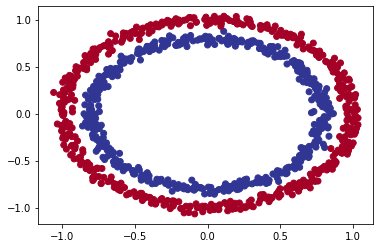

In [6]:
# Visualizeing the data
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that's small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels

X_sample = X[0]
y_sample = y[0]

print(f"Values for 1 sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for 1 sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for 1 sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for 1 sample of X: (2,) and the same for y: ()


### 1.2 Turn Data into Tensors and Create Train & Test Split

In [9]:
import torch
torch.__version__

'2.3.0+cpu'

In [10]:
# Turn data into torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
# Split data into train and test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # test_size = 0.2 indicates 20% test set 80% training set

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on GPU if available.
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [13]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:
1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Creates 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass of the model
4. Instantiate an instance of our model class and send it to the target device

In [14]:
X_train.shape

torch.Size([800, 2])

In [15]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling our data
        """
        for multi layer models, in_features of 1 layer should be = out_features of last layer
        the out_features of the last layer should be = expected y parameters
        """
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x))    # x -> layer_1 -> layer_2

In [16]:
# 4. Instantiate an instance of our model class and send it to our target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
next(model_0.parameters()).device

device(type='cpu')

In [18]:
# Replicating that model using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [19]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

We don't need to create the forward function and write `self.layer_2(self.layer_1(x))`, `nn.Sequential` does it for us.

Rewriting the model_0 properly using `nn.Sequential`

In [20]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling our data
        """
        for multi layer models, in_features of 1 layer should be = out_features of last layer
        the out_features of the last layer should be = expected y parameters
        """
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        ).to(device)
        
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.two_linear_layers(x)

In [21]:
model_0 = CircleModelV0()
model_0

CircleModelV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [22]:
model_0.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[ 0.5741,  0.2030],
                      [-0.4369, -0.0237],
                      [-0.0480, -0.4293],
                      [-0.2819, -0.0346],
                      [-0.3744, -0.1437]])),
             ('two_linear_layers.0.bias',
              tensor([-0.2993, -0.0462, -0.0173,  0.0578, -0.1229])),
             ('two_linear_layers.1.weight',
              tensor([[-0.1871, -0.3032,  0.4022,  0.4303,  0.1950]])),
             ('two_linear_layers.1.bias', tensor([0.0764]))])

number of weight samples in a layer = `in_features` * `out_features`,

Therefore, 0.weight (layer 0's weights) have 10 samples (2 `in_features` * 5 `out_features`)

and 1.weight has 5 samples (5 `in_features` * 1 `out_features`)

number of bias samples in a layer = `out_features`

Therefore, 0.bias = 5 = `out_features`

and 1.bias = 1 = `out_features`

In [23]:
# Making predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
    print(f"Length of test_samples: {len(X_test)}, Shape: {X_test.shape}")
    print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
    print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test_samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [-0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [24]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Loss functions:
* For regression, MAE or MSE is preferred.
* For classification, binary cross entropy or categorical cross entropy is preferred.

Optimizers:
* SGD and Adam are commonly used.

* We are going to use `torch.nn.BCEWithLogitsLoss()` as our loss function
* Logits are the output of the neural network before the activation function is applied.

In [25]:
# Setup the loss function
# loss_fn = nn.BCELoss()                # Requires inputs to have gone through the sigmoid activation function
loss_fn = nn.BCEWithLogitsLoss()        # Has sigmoid activation function built in, more numeric stability
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.1)

In [26]:
# Calculate accuracy - what % of examples does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()     # .item() converts tensor to number
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train Model

To train our model, we need to build a training loop:
1. Forward Pass
2. Calculate the Loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (Gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these logits to prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary cross entropy and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [27]:
# View the 1st 5 outputs of the forward pass on the test data

model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0429],
        [-0.0991],
        [ 0.3504],
        [-0.0440],
        [ 0.2477]])

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [29]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5107],
        [0.4752],
        [0.5867],
        [0.4890],
        [0.5616]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [30]:
torch.round(y_pred_probs)

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [31]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of the extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 0., 1., 0., 1.])

### 3.2 Build a training and testing loop

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))       # Turn logits -> pred probs -> pred labels
    
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)       # nn.BCEWithLogitsLoss expects raw logits as inputs
    acc = accuracy_fn(y_true = y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (Backpropagation)
    loss.backward()
    
    # 5. Optimizer step (Gradient descent)
    optimizer.step()
    
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)
        
    # Printing out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70233, Acc: 51.38% | Test loss: 0.69286 | Test Acc: 53.50%
Epoch: 10 | Loss: 0.69939, Acc: 50.75% | Test loss: 0.69141 | Test Acc: 53.00%
Epoch: 20 | Loss: 0.69771, Acc: 50.38% | Test loss: 0.69084 | Test Acc: 53.00%
Epoch: 30 | Loss: 0.69665, Acc: 49.88% | Test loss: 0.69067 | Test Acc: 53.00%
Epoch: 40 | Loss: 0.69593, Acc: 49.62% | Test loss: 0.69068 | Test Acc: 54.00%
Epoch: 50 | Loss: 0.69540, Acc: 49.00% | Test loss: 0.69077 | Test Acc: 53.00%
Epoch: 60 | Loss: 0.69500, Acc: 49.12% | Test loss: 0.69091 | Test Acc: 54.00%
Epoch: 70 | Loss: 0.69469, Acc: 48.75% | Test loss: 0.69107 | Test Acc: 54.00%
Epoch: 80 | Loss: 0.69443, Acc: 48.75% | Test loss: 0.69124 | Test Acc: 53.50%
Epoch: 90 | Loss: 0.69422, Acc: 49.12% | Test loss: 0.69140 | Test Acc: 53.00%


As accuracy is close to 50%, our model is as good as guessing.

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it, let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()`.

In [33]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path('helper_functions.py').is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


c:\Users\Vansh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


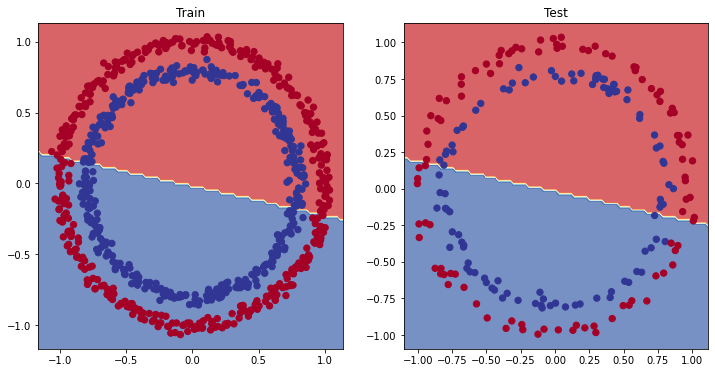

In [34]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)            # Rows, columns, index
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

The model just draws a line through the data but the data isn't segregated properly through that line.

Training the model for 1000 epochs instead...

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))       # Turn logits -> pred probs -> pred labels
    
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)       # nn.BCEWithLogitsLoss expects raw logits as inputs
    acc = accuracy_fn(y_true = y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (Backpropagation)
    loss.backward()
    
    # 5. Optimizer step (Gradient descent)
    optimizer.step()
    
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)
        
    # Printing out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69405, Acc: 48.75% | Test loss: 0.69157 | Test Acc: 53.00%
Epoch: 10 | Loss: 0.69390, Acc: 49.12% | Test loss: 0.69174 | Test Acc: 52.50%
Epoch: 20 | Loss: 0.69378, Acc: 49.25% | Test loss: 0.69190 | Test Acc: 54.00%
Epoch: 30 | Loss: 0.69368, Acc: 49.25% | Test loss: 0.69205 | Test Acc: 53.00%
Epoch: 40 | Loss: 0.69359, Acc: 48.50% | Test loss: 0.69220 | Test Acc: 53.50%
Epoch: 50 | Loss: 0.69351, Acc: 49.38% | Test loss: 0.69234 | Test Acc: 51.00%
Epoch: 60 | Loss: 0.69345, Acc: 49.00% | Test loss: 0.69247 | Test Acc: 52.00%
Epoch: 70 | Loss: 0.69339, Acc: 49.38% | Test loss: 0.69260 | Test Acc: 52.50%
Epoch: 80 | Loss: 0.69335, Acc: 49.62% | Test loss: 0.69272 | Test Acc: 49.00%
Epoch: 90 | Loss: 0.69330, Acc: 49.12% | Test loss: 0.69283 | Test Acc: 50.00%
Epoch: 100 | Loss: 0.69327, Acc: 50.12% | Test loss: 0.69294 | Test Acc: 49.00%
Epoch: 110 | Loss: 0.69323, Acc: 50.12% | Test loss: 0.69304 | Test Acc: 47.50%
Epoch: 120 | Loss: 0.69321, Acc: 50.00% | Test loss

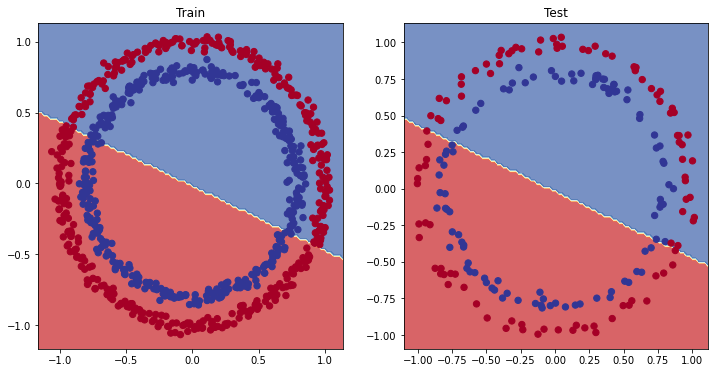

In [36]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)            # Rows, columns, index
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

It is still drawing the same line, the accuracy also doesn't improve much despite training it for 1000 epochs.

## 5. Improving a model (from a model perspective)

* Add more layers - give the models more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer - increase the number of epochs
* Changing the activation function
* Change the learning rate

These options are from a model's perspective as they deal directly with the data, rather than the model.

And because these options are all values we (as ML engineers) can change, they are referred to as **hyperparameters**.

Let's try and improve our models by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [37]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        # z = self.layer_1(x)           # Logits are signified by the variable z
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x)))      # This way of writing operations leverages speed-ups where possible

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [39]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()
    
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))   # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (backpropagation)
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step()
    
    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


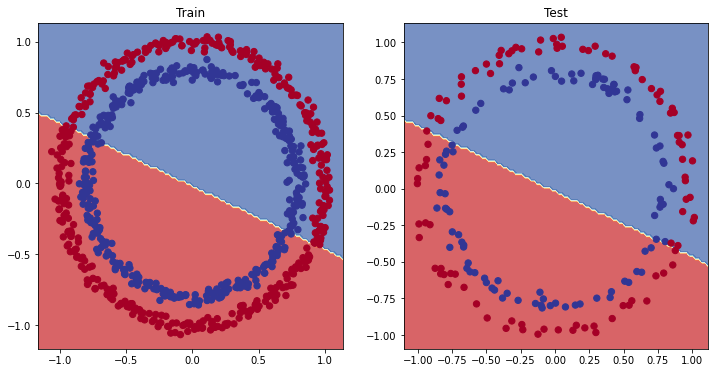

In [40]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)            # Rows, columns, index
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [41]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias         # Linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [42]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Checking the length
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

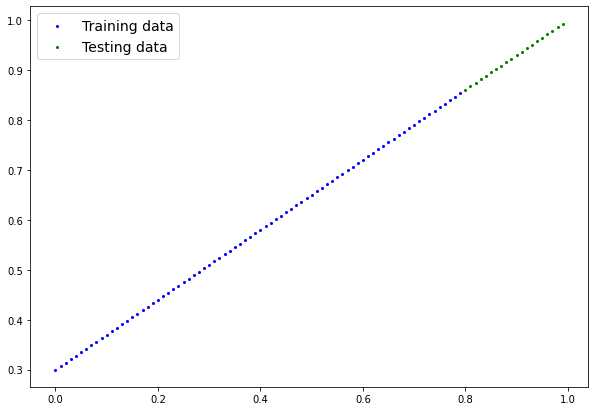

In [43]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression,
                 test_data=X_test_regression, test_labels=y_test_regression)

In [44]:
X_train_regression[:5], y_train_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

### 5.2 Adjusting `model_1` to fit a straight line

In [45]:
# Same architecture as model_1 (but using nn.Sequential) & changing the no. of input features from 2 to 1
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [46]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [47]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
    
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


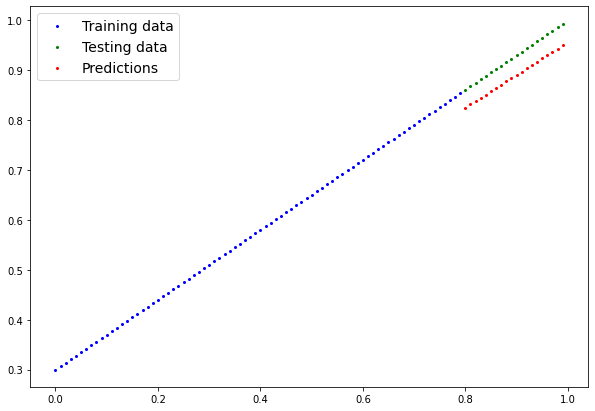

In [48]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression, predictions=y_preds)

## 6. The missing piece: non-linearity

"What patterns could youd draw if you were given an infinite amount of straight & non-straight lines?"

Or in ML terms, an infinite (but reallity it is finite) of linear & non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

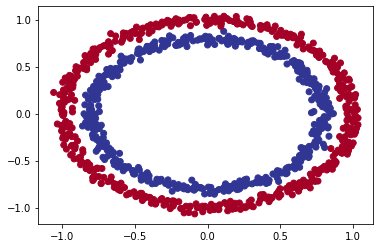

In [49]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:,0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [50]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity
* Linear = straight lines
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [51]:
# Build a model with a non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        # ReLU is a non-linear activation function
        self.relu = nn.ReLU()           # ReLU is rectified linear unit. o/p = 0 if x<0, else x
    
    def forward(self, x):
        # Where should we put our activation functions?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))    # We pass ReLU after every layer

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [52]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [53]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
    ### Training
    model_3.train()
    
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))       # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate the loss 
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)
    
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929 | Accuracy: 50.00% | Test Loss: 0.6932 | Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.6912 | Accuracy: 52.88% | Test Loss: 0.6910 | Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.6898 | Accuracy: 53.37% | Test Loss: 0.6894 | Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.6879 | Accuracy: 53.00% | Test Loss: 0.6872 | Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.6852 | Accuracy: 52.75% | Test Loss: 0.6841 | Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.6810 | Accuracy: 52.75% | Test Loss: 0.6794 | Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.6751 | Accuracy: 54.50% | Test Loss: 0.6729 | Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.6666 | Accuracy: 58.38% | Test Loss: 0.6632 | Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.6516 | Accuracy: 64.00% | Test Loss: 0.6476 | Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.6236 | Accuracy: 74.00% | Test Loss: 0.6215 | Test Accuracy: 79.00%


### 6.4 Evaluating a model trained on non-linear activation function

In [54]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:5], y_test[:5]

(tensor([1., 0., 1., 0., 0.]), tensor([1., 0., 1., 0., 1.]))

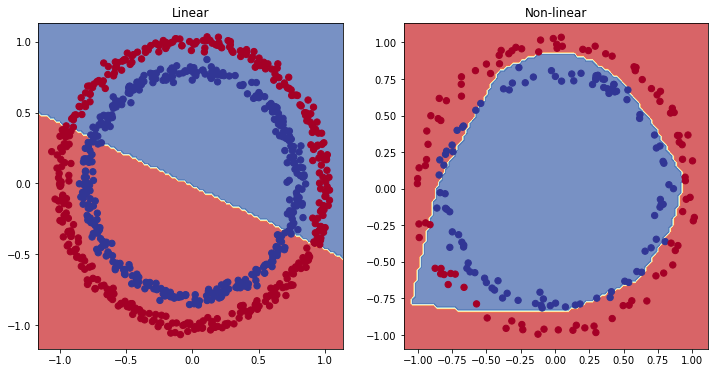

In [55]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Linear")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Non-linear")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than telling the model what to learn, we give it the data to discover patterns and it tries to figure out the patterns on it's own.

And these tools are linear and non-linear functions.

In [57]:
# Creating a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)

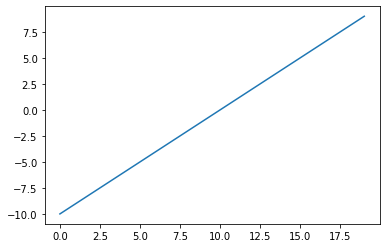

In [58]:
# Visualizing the data
plt.plot(A)

In [59]:
# Defining the ReLU activation function ourselves
def relu(x):
    return torch.maximum(torch.tensor(0), x)        # Inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

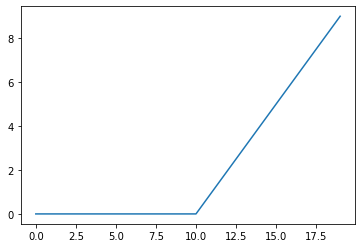

In [60]:
# Plotting ReLU
plt.plot(relu(A))

In [61]:
# Now let's do the same for sigmoid
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

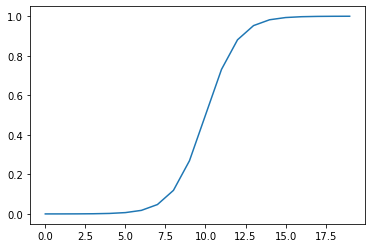

In [62]:
plt.plot(torch.sigmoid(A))

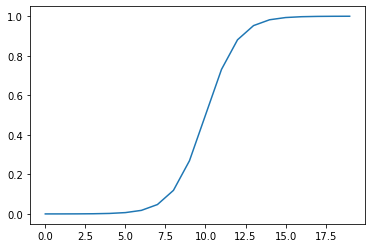

In [63]:
plt.plot(sigmoid(A))        # We get the same graph

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs dog, spam vs not spam, fraud vs not fraud)
* Multiclass classification = more than one thing or another (cat vs dog vs chicken)

### 8.1 Create a toy multiclass dataset

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES,
                            center_std=1.5, random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split into train and test set
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob)